In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pymysql
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, f

In [54]:
import os
def pickleLoad(file):
    if os.path.isfile(file):        
        with open(file,"rb") as fr:
            dataframe = pickle.load(fr)
        return dataframe
    else:  
        %run -i './getTrainTestSet/getTrainTestSet_interpolation.py' 

In [56]:
# load train, test set data

X_train = pickleLoad('./dataset/dataset_interpolation/X_train.pkl')
X_test = pickleLoad('./dataset/dataset_interpolation/X_test.pkl')
y_train = pickleLoad('./dataset/dataset_interpolation/y_train.pkl')
y_test = pickleLoad('./dataset/dataset_interpolation/y_test.pkl')
ccsi = pickleLoad('./dataset/dataset_interpolation/ccsi.pkl')
predictors = pickleLoad('./dataset/dataset_interpolation/predictors.pkl')

In [58]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Step3. Modeling
### model  GAM

* model fitting

* pyGam 설치 : pip install pyGAM

In [59]:
lams = np.random.rand(100, 7) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 
model_gam =  LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)+ s(6)).gridsearch(X_train_scaled, y_train, lam=lams)
model_gam.summary()

100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      39.846
Link Function:                     IdentityLink Log Likelihood:                                  -682.0882
Number of Samples:                          201 AIC:                                             1445.8684
                                                AICc:                                            1467.3474
                                                GCV:                                                17.616
                                                Scale:                                             11.4682
                                                Pseudo R-Squared:                                   0.8804
Feature Function                  Lam

<ipython-input-59-0a5ae54c26d2>:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model_gam.summary()


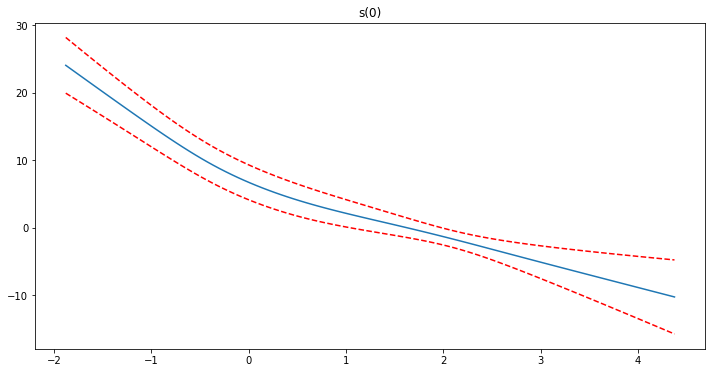

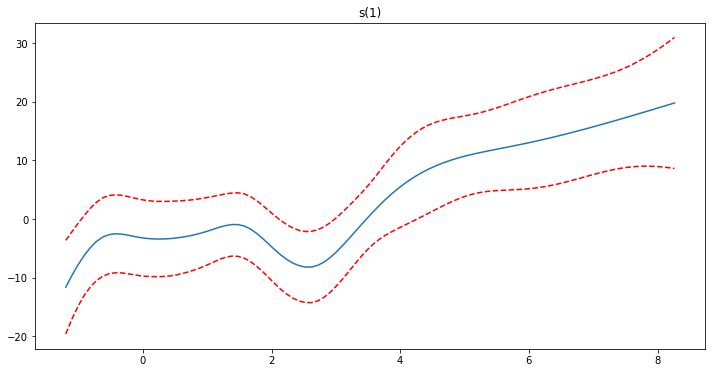

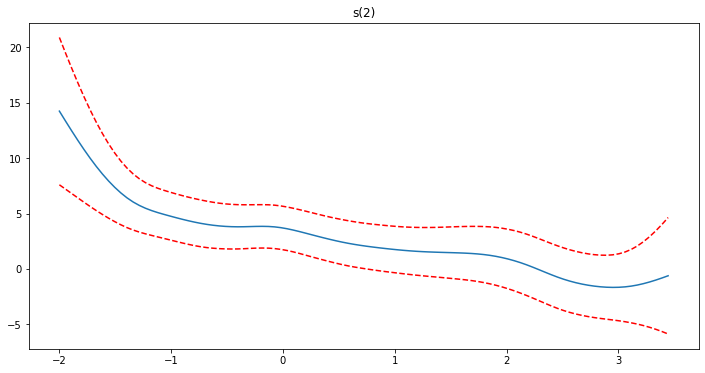

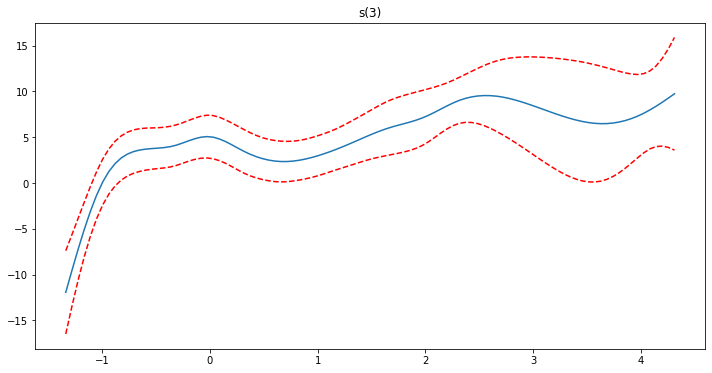

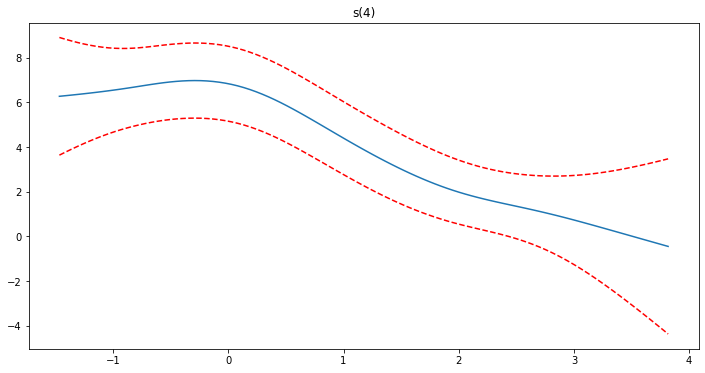

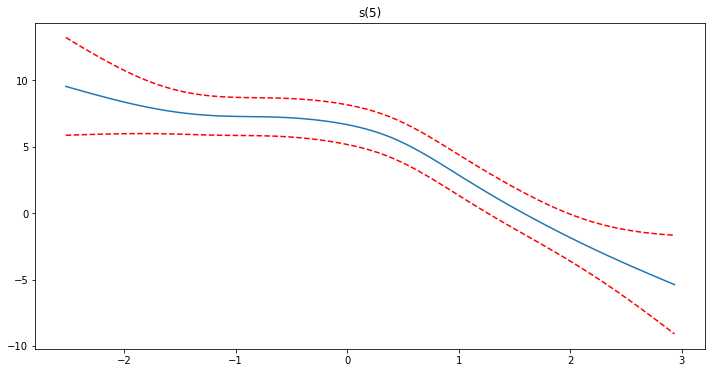

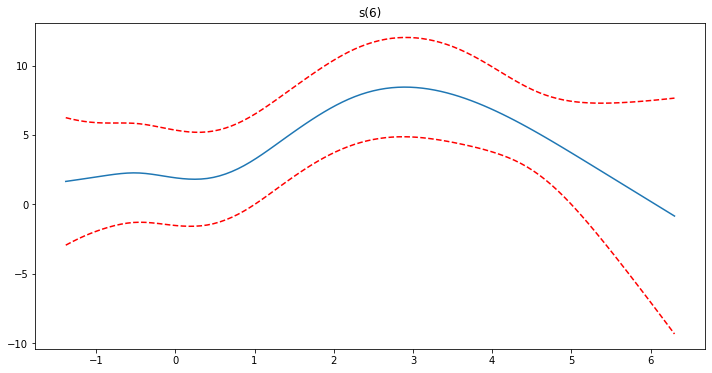

In [60]:
for i, term in enumerate(model_gam.terms):
    if term.isintercept:
        continue
    XX = model_gam.generate_X_grid(term=i)
    pdep, confi = model_gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [61]:
y_pred = model_gam.predict(X_test_scaled) # y_pred: test set을 넣어서 얻은 예측 값
y_pred

array([ 95.9506334 ,  91.28808337, 105.66818069,  76.68899724,
        65.1890348 , 102.79667903,  93.49365388,  94.77971551,
       103.30273147, 100.67454139,  97.98210091,  98.04907125,
        95.94491524,  95.67919716, 102.10577443,  95.54169581,
       109.65898778, 104.55218584, 103.33708072,  89.47967214,
       100.01518691,  97.68275424,  97.89384649, 103.86091254,
       111.18147963, 105.15251753, 104.75582133,  98.83523205,
       103.69760186, 101.53215336, 104.0178252 , 106.6917385 ,
        89.06574643, 105.31956781,  77.77231585, 102.28340317,
       102.88516138,  99.12491871, 105.03293392,  93.98954708,
       106.06684246, 109.78344654, 102.15105367, 101.63662186,
        93.99175672,  96.15613083, 101.79069019,  99.97053312,
        99.23201058, 106.04331782,  97.4604921 ])

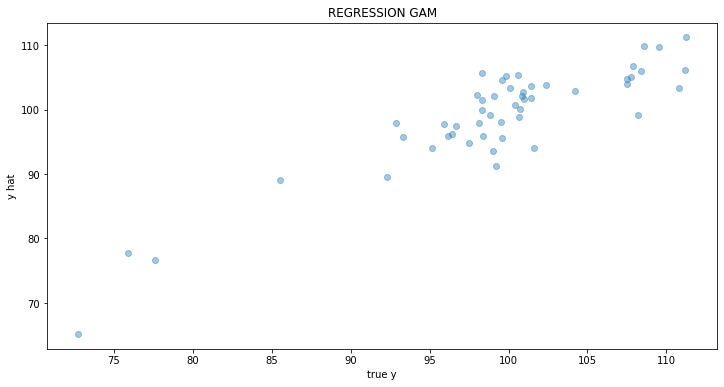

In [62]:
# test set에 대한 실제값과 예측 값의 추세 확인
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("true y")
plt.ylabel("y hat")
plt.title("REGRESSION GAM")
plt.show()

In [73]:
y_pred_train = model_gam.predict(X_train_scaled)
print("training RMSE: ", np.sqrt(mean_squared_error(y_pred_train, y_train))) 
print("test RMSE: ", np.sqrt(mean_squared_error(y_pred, y_test)))

training RMSE:  3.032287852973822
test RMSE:  3.6988744802953555


## Step4. Validate

여러 모델들을 활용하여, validating 하는 단계

## Step5. Visualization
### weekly record 예측하기(weekly CCSI)

In [63]:
# weekly 레코드들을 예측 모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi = model_gam.predict(scaler.transform(predictors[['keyword1','keyword2','keyword3','keyword4','keyword5','google','naver']]))

In [64]:
# tmp = pd.merge(predictors, ccsi).drop(['id'], axis=1)
tmp = pd.merge(predictors, ccsi)

tmp['pred'] = pred_ccsi
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred
0,2016,1,4,825,419,437,588,168,53.0,26.05846,101.525,100.976147
1,2016,1,11,770,348,351,388,182,58.0,25.16599,100.850,100.612987
2,2016,1,18,918,422,441,363,147,74.0,27.38639,100.175,95.575679
3,2016,1,25,1067,425,567,393,148,59.0,24.72622,99.500,96.986808
4,2016,2,1,899,341,485,297,110,63.0,23.01888,99.040,93.493654


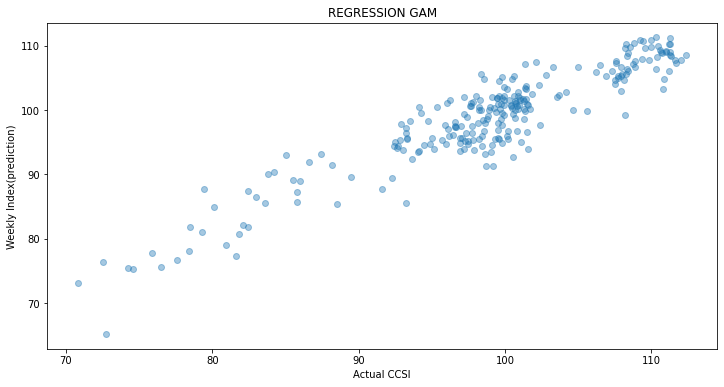

In [65]:
# true와 pred의 추세 확인
plt.scatter(tmp['ccsi'], tmp['pred'], alpha=0.4)
plt.xlabel("Actual CCSI")
plt.ylabel("Weekly Index(prediction)")
plt.title("REGRESSION GAM")
plt.show()

In [66]:
# weekly별 단기지표 값에 대한 MSE
print("MSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred'])))

MSE about weekly CCSI:  3.1784954435596373


### visualization
* 시계열 그래프

<ipython-input-67-1518bb3e2a4c>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


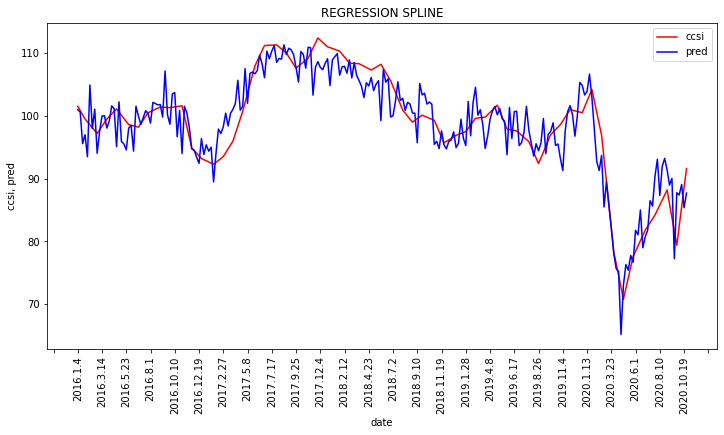

In [67]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("REGRESSION SPLINE")
plt.legend()
plt.show()

<ipython-input-68-fa4f97434e95>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


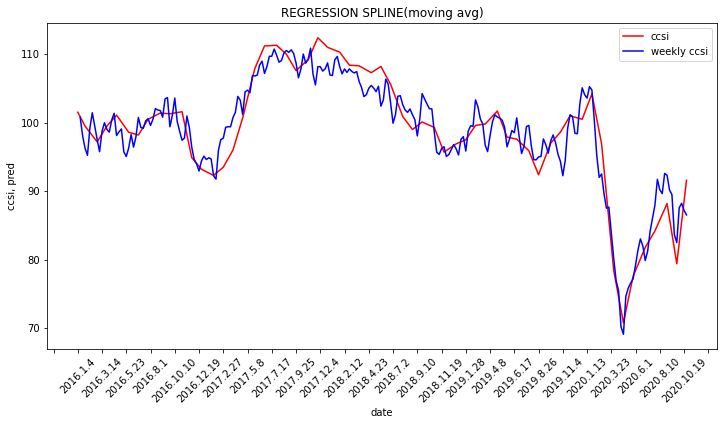

In [68]:
rolling = pd.Series.rolling(tmp['pred'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("REGRESSION SPLINE(moving avg)")
plt.legend()
plt.show()

## Step6. Develop weekly CCSI(주간 경기선행지수)

In [69]:
weekly_CLI = []
for i in range(len(tmp)):
    if i == 0 :
        cli = tmp.pred.iloc[i]
        weekly_CLI.append(cli)
        continue
    
    cli = (tmp.pred.iloc[i-1] + tmp.pred.iloc[i]) / 2
    weekly_CLI.append(cli)
    
tmp['weeklyCLI'] = weekly_CLI
tmp

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred,date,weeklyCLI
0,2016,1,4,825,419,437,588,168,53.0,26.05846,101.525,100.976147,2016.1.4,100.976147
1,2016,1,11,770,348,351,388,182,58.0,25.16599,100.850,100.612987,2016.1.11,100.794567
2,2016,1,18,918,422,441,363,147,74.0,27.38639,100.175,95.575679,2016.1.18,98.094333
3,2016,1,25,1067,425,567,393,148,59.0,24.72622,99.500,96.986808,2016.1.25,96.281244
4,2016,2,1,899,341,485,297,110,63.0,23.01888,99.040,93.493654,2016.2.1,95.240231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020,9,28,489,90,114,27,78,63.0,25.29102,79.400,87.747896,2020.9.28,82.504831
248,2020,10,5,816,183,177,47,78,81.0,28.63240,82.450,87.397024,2020.10.5,87.572460
249,2020,10,12,857,199,176,55,91,82.0,26.85177,85.500,89.065746,2020.10.12,88.231385
250,2020,10,19,911,155,143,64,129,93.0,27.25273,88.550,85.354478,2020.10.19,87.210112
